In [17]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import random

import torch

In [22]:
def load_image(fname):
    img = np.mean(imread(fname), axis=2)  # Grayscale
    img = (img[:, :]) / 255.0
    return 1 - img  # black = 1, white = 0

def cloud_transform(image, n_samples=1000):
    image = image > 0.1
    samples = np.vstack([np.where(image)[1] / image.shape[1],
                         1 - np.where(image)[0] / image.shape[0]]).T
    samples = samples - samples.mean(axis=0)
    samples = samples * 2
    # add a little bit of noise to avoid the sampling patterns
    samples += np.random.randn(samples.shape[0], 2) * 2e-3
    samples = samples[random.sample([i for i in range(len(samples))], n_samples)]
    return samples

In [10]:
obelix = load_image('obelix.jpg')
asterix = load_image('asterix.jpg')
#plt.imshow(obelix,cmap='Greys')
#plt.axis('off')

/tmp/ipykernel_285054/3379521651.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = np.mean(imread(fname), axis=2)  # Grayscale


## 0/ Define source and target distributions

In [25]:
target = cloud_transform(obelix, n_samples=1000)
source = cloud_transform(asterix, n_samples=1000)

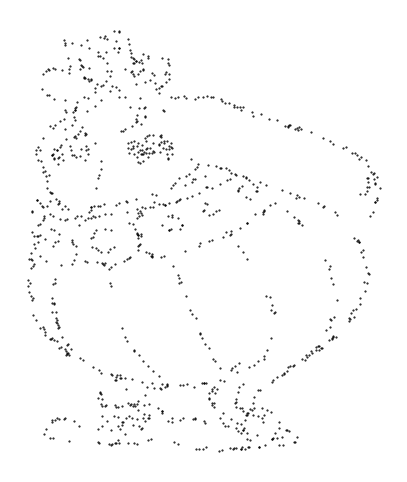

In [24]:
plt.figure(figsize=(5,6))
plt.scatter(cloud_obelix[:,0], cloud_obelix[:,1],marker='.',c='k',s=1)
plt.axis('off')
plt.show()

## 1/ General framework

The goal of flow matching is to transform a source distribution $p_0$ into the target distribution $p_1$. To do so, we consider a probability path between $p_0$ and $p_1$ that go through intermediate marginal distributions $(p_t), t\in[0,1]$. We also define a time-dependent flow $\Psi: [0,1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ such that pushes $p_0$ to $p_t$: $p_t=[\Psi_t]*p_0$

The flow is defined with an Ordinary Differential Equation (ODE):
$\frac{d}{d t} \Psi_t(x) & =v_t(\Psi_t(x))$

Marginal distribution:\
$p_t(x)=\int p_t\left(x \mid z\right) q\left(z\right) d z$ \
Velocity field:\
$u_t(x)=\int u_t\left(x \mid z\right) \frac{p_t\left(x \mid z\right) q\left(z\right)}{p_t(x)} d z$

## 2/ Flow matching from gaussian

## 3/ Flow matching from data distribution